### About
### Build a machine learning model that can accurately classify the images based on the disease present.

### Import necessary packages

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_auc_score
from sklearn.metrics import confusion_matrix
from tqdm import tqdm_notebook
import xgboost as xgb
from PIL import Image, ImageDraw
import skimage.color
import skimage.util
import imagehash
import cv2
import os
import re
import itertools
#import distance
import time
import warnings
warnings.filterwarnings("ignore")


### Import train and test data

In [ ]:
train=pd.read_csv("/kaggle/input/the-leaf-disease-classification/train.csv")
test=pd.read_csv("/kaggle/input/the-leaf-disease-classification/test.csv")

### Target label distribution

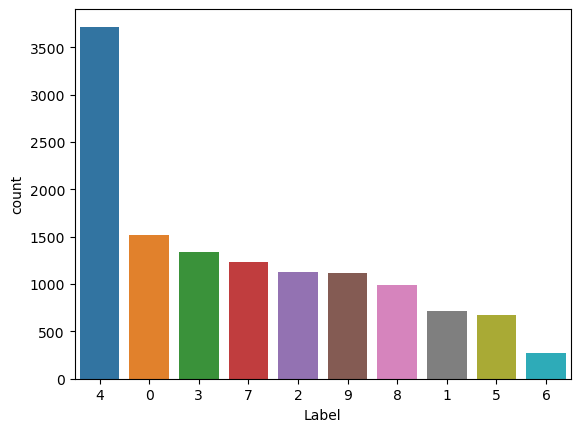

In [ ]:
sns.countplot(x=train['Label'],order=train['Label'].value_counts().index);

In [ ]:
train['Label'].value_counts()

4    3719
0    1519
3    1335
7    1236
2    1127
9    1122
8     989
1     719
5     678
6     268
Name: Label, dtype: int64

### The above plot explains that there is an imbalance between the classes.

### Create train and validation data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train['Image'], train['Label'],
                                                                    test_size=0.2,
                                                                    random_state=42,
                                                                   stratify=train['Label'])

In [ ]:
train_1=pd.concat([X_train,y_train],axis=1)
val_1=pd.concat([X_test,y_test],axis=1)

### Function to convert image to 1-D vector.

In [ ]:
def createfeat(path,df):
    feat=[]
    for file in tqdm_notebook(df['Image']):
        img=Image.open(f"{(os.path.join(path, file))}").convert("L")
        im=img.resize((128,128))
        image_array = np.array(im)

        image_array = 255 - image_array

        normalized_image = image_array / 255.0
        feat.append(normalized_image.flatten())
    return feat

### Create 1-D vector for train images

In [ ]:
train_feat=createfeat('/kaggle/input/the-leaf-disease-classification/train',train_1)

  0%|          | 0/10169 [00:00<?, ?it/s]

### Create 1-D vector for validation images

In [ ]:
val_feat=createfeat("/kaggle/input/the-leaf-disease-classification/train",val_1)

  0%|          | 0/2543 [00:00<?, ?it/s]

#### Create XGBoost classifier with default parameters.

In [ ]:
clf=xgb.XGBClassifier()

### Fit the data

In [ ]:
clf.fit(train_feat, y_train,eval_set=[(val_feat,y_test)],eval_metric=['merror','mlogloss'],
        early_stopping_rounds=10, verbose=True)

### Predict the label for validation data

In [ ]:
val_pred=clf.predict(val_feat)

### Validation data accuracy score

In [ ]:
print(f"Validation data accuracy:{accuracy_score(y_test,val_pred).round(2)*100}")

Validation data accuracy:70.0


### Let's see the sample images with actual labels and predicted labels.

In [ ]:
val_df_final=val_1
val_df_final['predicted']=val_pred

### Function to read image

In [ ]:
def img_read(path,im ,new_size=False):
    img = Image.open(f"{(os.path.join(path, im))}")

    if new_size:
        img=img.resize((224,224))
        return img
    else:
        return img

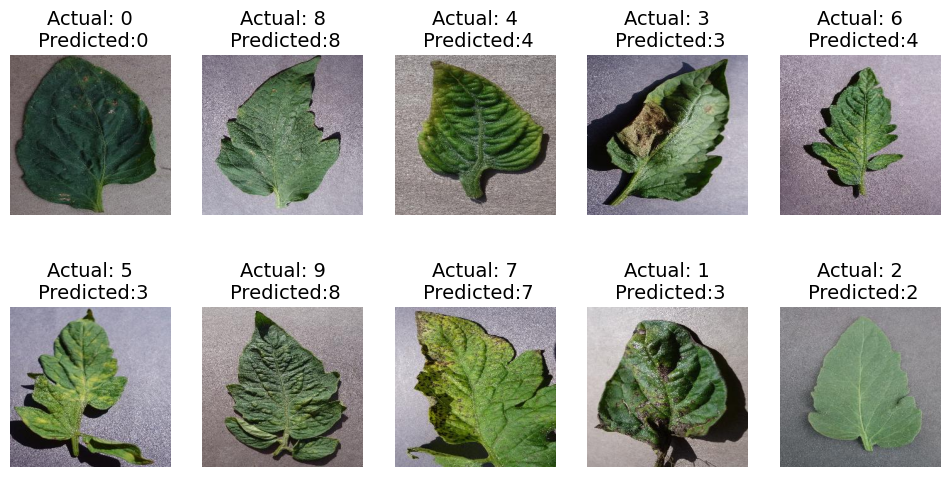

In [ ]:
path="/kaggle/input/the-leaf-disease-classification/train"
fig=plt.figure(figsize=(12,6))
for i,image in enumerate(val_df_final.groupby('Label').head(1)['Image'].values):
    _=plt.subplot(2,5,i+1)
    img=img_read(path,val_df_final[val_df_final['Image']==image]['Image'].head(1).values[0])
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Actual: {val_df_final[val_df_final['Image']==image]['Label'].head(1).values[0]}\n Predicted:{val_df_final[val_df_final['Image']==image]['predicted'].head(1).values[0]}",fontsize=14)

In [ ]:
def confusion_matrix_plot(y_test,val_pred):
    fig, (ax1) = plt.subplots(nrows=1, figsize=(6, 6))
    sns.heatmap(confusion_matrix(y_test,val_pred), annot=True,fmt=".0f", cmap="Blues");
    ax1.set_title("Confusion Matrix")
    ax1.set_xlabel("Predicted Class")
    ax1.set_ylabel("Actual Class")
    ax1.yaxis.set_ticklabels(set(y_test),rotation=0)

### Confusion matrix for validation data

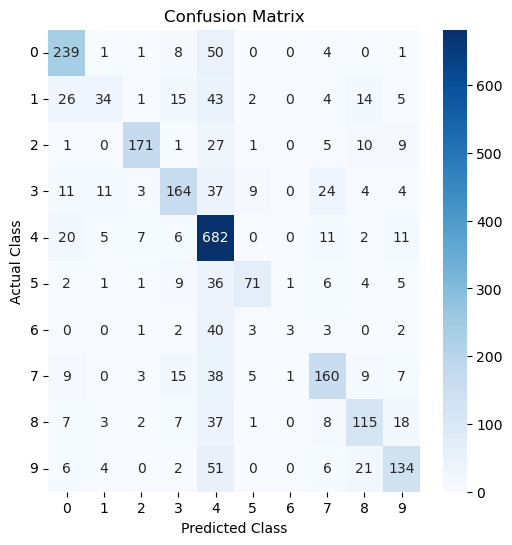

In [ ]:
confusion_matrix_plot(y_test,val_pred)

### Create 1-D vector for test images

In [ ]:
test_feat=createfeat("/kaggle/input/the-leaf-disease-classification/test",test)

### Predict the test data

In [ ]:
test_pre=clf.predict(test_feat)

### Submission dataframe

In [ ]:
res=pd.DataFrame({'Label':test_pre})

In [ ]:
res.to_csv("xgboost_baseline_1.csv",index=False)